# Logistical Regression for Binary Classification


## Statistical Derivation

We have $n$ samples $(x_i, y_i)$, where $x_i$ in $\mathbb{R}^p$ and $y_i$ in \{0,1\}\.


---

### 1. Logistic Regression Model

The probability that $y_i = 1$ given $x_i$ is:

$$
P(y_i = 1 \mid x_i, \beta) = \frac{1}{1 + \exp(- x_i^T \beta)}
$$

The probability that \(y_i = 0\) is:

$$
P(y_i = 0 \mid x_i, \beta) = 1 - P(y_i = 1 \mid x_i, \beta) = \frac{\exp(- x_i^T \beta)}{1 + \exp(- x_i^T \beta)}
$$

---

### 2. Likelihood Function

For $n$ independent samples, the likelihood is:

$$
L(\beta \mid X, y) = \prod_{i=1}^{n} P(y_i \mid x_i, \beta)
= \prod_{i=1}^{n} \left[ \left(\frac{1}{1 + \exp(-x_i^T \beta)}\right)^{y_i} 
\left(1 - \frac{1}{1 + \exp(-x_i^T \beta)}\right)^{1 - y_i} \right]
$$

---

### 3. Log-Likelihood

Taking the logarithm:

$$
\ell(\beta \mid X, y) = \sum_{i=1}^{n} \left[ y_i \log\left( \frac{1}{1 + \exp(-x_i^T \beta)} \right) 
+ (1 - y_i) \log \left( 1 - \frac{1}{1 + \exp(-x_i^T \beta)} \right) \right]
$$

---

### 4. Simplify Terms

First term:

$$
y_i \log \left( \frac{1}{1 + \exp(-x_i^T \beta)} \right) = -y_i \log(1 + \exp(-x_i^T \beta))
$$

Second term:

$$
(1 - y_i) \log \left( \frac{\exp(-x_i^T \beta)}{1 + \exp(-x_i^T \beta)} \right)
= -(1 - y_i) x_i^T \beta - (1 - y_i) \log(1 + \exp(-x_i^T \beta))
$$

---

### 5. Combine Terms

So the simplified log-likelihood is:

$$
\ell(\beta \mid X, y) = \sum_{i=1}^{n} \left[ y_i x_i^T \beta - \log(1 + \exp(x_i^T \beta)) \right]
$$

---

### 6. Gradient of Negative Log-Likelihood

To use **gradient descent**, we minimize the **negative log-likelihood**, $\mathcal{L}(\beta) = -\ell(\beta)$.

We compute the gradient:

$$
\begin{aligned}
\frac{\partial \mathcal{L}(\beta)}{\partial \beta_j}
&= -\frac{\partial}{\partial \beta_j} \left[ y \log \sigma(x^T \beta) + (1 - y) \log(1 - \sigma(x^T \beta)) \right] \\
\\
&= -\left[ \frac{y}{\sigma(x^T \beta)} - \frac{1 - y}{1 - \sigma(x^T \beta)} \right] \cdot \frac{\partial}{\partial \beta_j} \sigma(x^T \beta) \\
\\
&= -\left[ \frac{y}{\sigma(x^T \beta)} - \frac{1 - y}{1 - \sigma(x^T \beta)} \right] \cdot \sigma(x^T \beta)[1 - \sigma(x^T \beta)] x_j \\
\\
&= -\left[ \frac{y - \sigma(x^T \beta)}{\sigma(x^T \beta)[1 - \sigma(x^T \beta)]} \cdot \sigma(x^T \beta)[1 - \sigma(x^T \beta)] x_j \right] \\
\\
&= -[y - \sigma(x^T \beta)] x_j \\
\\
&= [\sigma(x^T \beta) - y] x_j
\end{aligned}
$$

---

### 7. Vectorized Gradient (for all features)

For the full dataset:

$$
\nabla_\beta \mathcal{L}(\beta) = X^T \left[ \sigma(X \beta) - y \right]
$$


---

### Gradient Descent Update Rule

To minimize the negative log-likelihood, we update parameters with:

$$
\beta := \beta - \alpha \cdot \nabla_\beta \mathcal{L}(\beta)
$$

Where:

- $\alpha$ is the learning rate
- The update rule moves $\beta$ in the direction that reduces the loss


## Python Implementation

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification    
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim

## Dataset

In [116]:
X, Y = make_classification(
    n_samples=200, 
    n_features=3, 
    n_informative=2, 
    n_redundant=0, 
    random_state=42
)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train_tensor = torch.FloatTensor(X_train)
Y_train_tensor = torch.FloatTensor(Y_train).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test)
Y_test_tensor = torch.FloatTensor(Y_test).view(-1, 1)

### Method 1: From-scratch method with Numpy

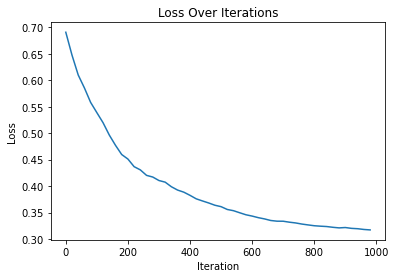

Accuracy: 77.50%


In [125]:
# Sigmoid
def sigmoid(X):
    return 1 / (1 + np.exp(-X))

# SGD update
def compute_SGD(X, y, beta, steps, lr):
    for _ in range(steps):
        i = np.random.randint(len(y))
        xi = X[i:i+1]   # shape (1, n_features)
        yi = y[i:i+1]   # shape (1,)
        
        pred = sigmoid(xi.dot(beta))      # shape (1,)
        grad = xi.T.dot(pred - yi)        # shape (n_features,)
        
        beta -= lr * grad.flatten()
    return beta

# Logistic regression
def logistic_regression(X, Y, lr=1e-2, steps=1000, report_every=20):
    # Add bias term
    X_bias = np.hstack([X, np.ones((X.shape[0], 1))])
    beta = np.zeros(X_bias.shape[1])
    lls = []
    
    for step in range(steps):
        beta = compute_SGD(X_bias, Y, beta, steps=1, lr=lr)
        
        if step % report_every == 0:
            z = X_bias.dot(beta)
            pred = sigmoid(z)
            ll = -np.mean(Y * np.log(pred) + (1 - Y) * np.log(1 - pred))
            lls.append(ll)
    
    return beta, lls

def predict(X, beta):
    X_bias = np.hstack([X, np.ones((X.shape[0], 1))])
    probs = sigmoid(X_bias.dot(beta))
    return (probs >= 0.5).astype(int)

# Plot function
def plot_loss(loss):
    plt.plot(range(0, len(loss) * 20, 20), loss)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss Over Iterations')
    plt.show()

# Train
beta, lls = logistic_regression(X_train, Y_train, lr=1e-2, steps=1000)
plot_loss(lls)

# Predict
Y_pred = predict(X_test, beta)
accuracy = np.mean(Y_pred == Y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')


### Method 2: Sklearn method

In [118]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train, Y_train)

Y_pred_prob = model.predict_proba(X_test)[:, 1]  
Y_pred = model.predict(X_test)                    

acc = accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {acc * 100:.2f}%')

Accuracy: 77.50%


### Method 3: From-scratch method with PyTorch

In [119]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

In [ ]:
class Trainer:
    def __init__(self, model, lr=0.01):
        self.model = model
        self.lr = lr
        self.loss_func = nn.BCELoss()
        self.optimizer = optim.SGD(self.model.parameters(), lr=self.lr)

    def train(self, X, Y, epochs=1, steps=1000, log_every=20):
        self.model.train()  
        loss_list = []

        for epoch in range(epochs):
            for step in range(steps): 
                self.optimizer.zero_grad()
                outputs = self.model(X)
                loss = self.loss_func(outputs, Y)
                loss.backward()
                self.optimizer.step()

                # logging
                if (step + 1) % log_every == 0:
                    loss_list.append(loss.item())
                    # print(f"Epoch {epoch+1}, Step {step+1}/{steps}, Loss: {loss.item():.4f}")

        return loss_list

    def predict(self, X):
        self.model.eval() 
        with torch.no_grad():
            return self.model(X)
    
    def evaluate(self, X, Y):
        self.model.eval()
        with torch.no_grad():
            probs = self.model(X)
            preds = (probs >= 0.5).float()
            correct = (preds == Y).sum().item()
            total = Y.size(0)
            acc = correct / total
        return acc


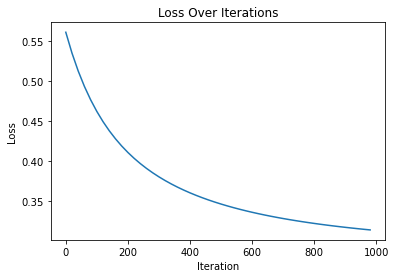

Test Accuracy: 77.50%


In [124]:
model = LogisticRegression(X_train.shape[1], 1)
trainer = Trainer(model, lr=1e-2)

losses = trainer.train(X_train_tensor, Y_train_tensor, epochs=1, log_every=20)
plot_loss(losses)

acc = trainer.evaluate(X_test_tensor, Y_test_tensor)
print(f'Test Accuracy: {acc * 100:.2f}%')